## Problem statement

Lending Club is a platform that connects people seeking personal loans with investors willing to lend money. It primarily deals with urban customers and needs to decide whether to approve a loan application based on the applicant's profile.

Credit loss, or financial loss, primarily comes from lending to risky applicants, those who might not repay the loan. These defaulters, often labeled as 'charged-off,' cause the most significant loss to lenders.

The main goal is to reduce credit loss. There are two scenarios to consider:

Approving loans for applicants likely to repay them is profitable for the company due to interest earnings. Rejecting such applicants results in lost business opportunities.

On the other hand, approving loans for applicants unlikely to repay may lead to financial losses for the company when they default.

In essence, the company's challenge is to strike a balance between maximizing profitable loans and minimizing the risk of financial losses.


## Objective

The goal is to find risky loan applicants in order to reduce credit loss. This case study focuses on identifying such applicants using exploratory data analysis (EDA).

In simpler terms, the company aims to discover the key factors that lead to loan default, the strong indicators of default. This knowledge will help the company manage its portfolio and assess risk effectively.

### Intial setup of python Libraries for Data and Visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fixing the warning by specifying dtype = object
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 120)

loan_data_df = pd.read_csv('loan.csv', dtype=object)
loan_detail_df = pd.read_excel('Data_Dictionary.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'Data_Dictionary.xlsx'

#### Reading Loan DF and creating Metadata

In [ ]:
print("Loan data shape:",loan_data_df.shape)
print("Loan data information")
print(loan_data_df.info())

### Metadata 

In [ ]:
#number of columns in Loan data
print("Number of Columns", loan_data_df.shape[1])
#number of rows in Loan data
print("Number of rows", loan_data_df.shape[0])
#number of duplicate values
print("Duplicate value in Loan data", loan_data_df.duplicated().sum())
#number of columns with only null value
print("Number of columns with null values",(loan_data_df.isnull().all(axis=0).sum()))
#numbers of rows with only null values
print("Number of rows with null values",(loan_data_df.isnull().all(axis=1).sum()))


# Data Cleaning

We will start the process of Data Cleaning here
*******************************************************************************************************************


###  Row Cleaning
        Delete summary row if any
        delete incorrect row
        delete empty row
        delete incorrect row
### Columns Cleaning
        Merge columns for creating unique identifiers if needed
        Split columns for more data: Split address to get State and City to analyse each separately
        Add column names: Add column names if missing
        Rename columns consistently: Abbreviations, encoded columns
        Delete columns: Delete unnecessary columns
        Align misaligned columns: Dataset may have shifted columns

In [ ]:
#delete the Loan columns containing only null values
loan_data_df.dropna(axis=1,how='all',inplace=True)

In [ ]:
#set to display maximum rows
pd.set_option('display.max_rows', None)
(loan_data_df.isna().sum()).sort_values()

In [ ]:
#dropping off columns with maximum values as null
columns_to_drop = ['desc','mths_since_last_delinq','mths_since_last_record','next_pymnt_d']
loan_data_df.drop(columns_to_drop,axis=1,inplace=True)

## Check the dataframe with unique values

In [ ]:
loan_data_df.apply(lambda x: x.nunique()).sort_values()

### Based on the result of nunique method, below columns were identified with same values

1.tax_liens -->                     1<br/>
2.delinq_amnt      -->              1<br/>
3.chargeoff_within_12_mths -->      1<br/>
4.acc_now_delinq               -->  1<br/>
5.application_type    -->           1<br/>
6.policy_code    -->                1<br/>
7.collections_12_mths_ex_med  -->   1<br/>
8.initial_list_status   -->         1<br/>
9.pymnt_plan            -->         1<br/>

Reading from the loan data dictonary above columns might be important but not this data sets due to common values for all the records, hence deleting these columns

In [ ]:
nunique_loan_columns = ['tax_liens','delinq_amnt','chargeoff_within_12_mths','acc_now_delinq','application_type','policy_code'
             ,'collections_12_mths_ex_med','initial_list_status','pymnt_plan']
loan_data_df.drop(columns=nunique_loan_columns,axis=1,inplace=True)

In [ ]:
#on further analysis of columns, we can drop the 
# zip_code - Does not have the full zip-code and the xx - value code be either same or different
# url - Does not provide relevant information
# member_id - this dataframe contain unique values only, so we can drop it as well
# emp_title - the are text and does not contribute 

nonrelevant_loan_column_values = ['zip_code','url','member_id','emp_title']
loan_data_df.drop(columns=nonrelevant_loan_column_values,axis=1,inplace=True)

### Standardising Value
    Numerical values
    Standardise units
### Invalid values
    Encode unicode properly 
    Correct the incorrect data types to the correct data types for ease of analysis.
    

In [ ]:
# updating the NAN value available in different columns to clean values
# pub_rec_bankruptcies - update the values with 'Not Available'
# emp_length - format the employee length correctly to Numerics values

loan_data_df.pub_rec_bankruptcies.fillna('Not Available',inplace=True)
loan_data_df.emp_length.fillna('0',inplace=True)
loan_data_df['emp_length'] = loan_data_df['emp_length'].apply(lambda x : x.replace('years','')
                                             .replace('+','')
                                             .replace('< 1','0.5')
                                             .replace('year',''))

### Remove extra characters like common prefix/suffix, leading/trailing/multiple spaces, etc.

In [ ]:
# Now that we have filtered out -irrelevant columns, let check and clean the columns values
# int_rate - remove % symbol, check dtype if object convert it to float
# revol_util - remove % symbol, check dtype if object convert it to float
# term - remove months from the term value
# emp_length - formatting the columns valye

loan_data_df['int_rate'] = loan_data_df['int_rate'].str.rstrip('%')
loan_data_df['revol_util'] = loan_data_df['revol_util'].str.rstrip('%')
loan_data_df['term'] = loan_data_df['term'].str.rstrip('months')


## Update the amount columns to numeric values

In [ ]:
# updating object type to numeric for amount columns
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','annual_inc','revol_bal',
                   'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','int_rate','dti','term']
loan_data_df[numeric_columns] = loan_data_df[numeric_columns].apply(pd.to_numeric)

## Create function doing common job such as plotting to reduce duplicate code

In [ ]:
# common function to find the outliers
# Find the median,Q1,Q3 and IQR
# min Outliners = Q1 - 1.5IQR
# max Outliners = Q3 + 1.5IQR

def findOutliers(df, column ):
    quat1 = df[column].quantile(0.25)
    quat3 = df[column].quantile(0.75)
    iqr = quat3 - quat1
    min_outliner = loan_q1 - (1.5*loan_q1)
    max_outliner = loan_q3 + (1.5*loan_q3)
    return {'quat1': quat1, 'quat3': quat3, 'iqr': iqr, 'min_outliner': min_outliner, 'max_outliner': max_outliner}
    
# Function to reduce the max outliners
def deleteMaxOutliers(df,column):
    max_outliers = findOutliers(df, column)['max_outliner']
    new_df = df[df[column] < max_outliers]
    return new_df

# Function to reduce the min outliners
def deleteMinOutliers(df,column):
    
    new_df = df[df[column] > findOutliers(df, column)['min_outliner']]
    print(new_df.head())
    return new_df

# function to plot Univariate Analysis
def plot_univariate_analysis(df,column):
    fig, p = plt.subplots(1,2, figsize=(14, 5))
    sns.histplot(df.loc[df[column].notnull(), column], kde=True,ax=p[0])
    sns.boxplot(x=column, data=df, ax=p[1])
    p[0].set_xlabel(column)
    p[1].set_xlabel(column)
    plt.tight_layout()
    plt.show()


# Function to plot unorder categorical analysis
def plot_cat_analysis(df,column1,column2 = None):
    plt.figure(figsize=(14, 8))
    sns.set_style('darkgrid')
    if None:
        ax = sns.countplot(x= column1, data=df,palette='mako')
        for container in ax.containers:
            ax.bar_label(container)
    else:
        ax = sns.countplot(x= column1, data=df,hue=column2, palette='mako')
        for container in ax.containers:
            ax.bar_label(container)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(column1, fontsize=10, color='white')
    ax.set_xlabel(column1, fontsize=10, color='white')
    ax.set_ylabel(column2, fontsize=10, color='white')
    plt.tight_layout()
    plt.show()
    


### Remove Outliners
    Find the median,Q1,Q3 and IQR
    min Outliners = Q1 - 1.5*IQR
    max Outliners = Q3 + 1.5*IQR

## Univariate Analysis 
   1.Quantative variable analysis </br>
   2.Categorical Analysis </br>
     # 2.1 Ordered </br>
     # 2.2 Unordered</br>

### 1.Loan Amount - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [ ]:
#univariate analysis of Loan amout sanctioned 
plot_univariate_analysis(loan_data_df,'loan_amnt')

#### Analysis
looking at the boxplot generated we can confirm that the most common loan amout ranges between 5k~14K

### 2. Funded amount - The total amount committed to that loan at that point in time.

In [ ]:
#univariate analysis of Loan amout sanctioned 
plot_univariate_analysis(loan_data_df,'funded_amnt')

#### Analysis
looking at the boxplot generated we can confirm that the most common funded amout ranges between 5k~15K

### 3. funded_amnt_inv - The total amount committed by investors for that loan at that point in time.

In [ ]:
#univariate analysis of funded_amnt_inv sanctioned 
plot_univariate_analysis(loan_data_df,'funded_amnt_inv')

#### Analysis
looking at the boxplot generated we can confirm that the most common funded_amnt_inv  ranges between 5k~15K

### 4.int_rate

In [ ]:
plot_univariate_analysis(loan_data_df,'int_rate')

#### Analysis
int_rate range from 5% to 22.5 percent, majority of the inreset rate liers between 8%~15%

### 5.installment

In [ ]:
plot_univariate_analysis(loan_data_df,'installment')

### Analysis
Majority of installment falls between 200 ~400 where max going till 800, we have few outliers too here

In [ ]:
#univariate analysis of annual income  
plot_univariate_analysis(loan_data_df,'annual_inc')

#### Analysis
as we can conclude from above plot that annual income have lots of outliers, let try to remove the outliers and </br>create the Plot again

In [ ]:
####univariate analysis of annual income after removing outliers from annual income
plot_univariate_analysis(deleteMaxOutliers(loan_data_df,'annual_inc'),'annual_inc')


### Analysis
After cleaning the outliners we have now clear graph, income group majorliy lies between 7k ~25k

### ******************************************************************************************************************

## Categorical Variable analysis

### unorder
Based on the analysis of column, We can identify below columns eligible for unorder categorical analysis

1. Home Ownership
2. Purpose
3. Address state
4. Loan Status


1. Home Ownership

In [ ]:
# catgorical analysis for number of loan application with respect to thier home ownership
plot_cat_analysis(loan_data_df,'home_ownership')

### Analysis
Categorical analysis for Home ownership shows that loan application are from consumer living in either 
1. Rented Home
2. Morgage Home
3. Own
4. other

2. Purpose

In [3]:
# catgorical analysis for number of loan application with respect to thier home ownership
plot_cat_analysis(loan_data_df,'purpose')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Based on the plot generated for Purpose of loan we can confirm tha, majority of loan is taken for 
1. debt consolidation
2. Credit Card

In [4]:
# catgorical analysis for location with respect to loan status
plot_cat_analysis(loan_data_df,'addr_state')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
1. most number of loan is take in "CA"
2. second is NY


### Categorical Variable Analysis
1. term
2. grade
3. emp_length
4. pub_rec_bankruptcies

1. Term

In [5]:
# catgorical analysis for Term
plot_cat_analysis(loan_data_df,'term')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
1. Majority of loan are in term of 36 month

2. Grade

In [6]:
# catgorical analysis for Grade 
plot_cat_analysis(loan_data_df,'grade')

NameError: name 'plot_cat_analysis' is not defined

#### Analysis
1. Grade B has higest number of loans

3. emp_length


In [7]:
# catgorical analysis for emp_length 
plot_cat_analysis(loan_data_df,'emp_length')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Majority of Loan is taken by people with 
1. 10 years of experience
2. 6 month of experience


4. pub_rec_bankruptcies

In [8]:
# catgorical analysis for pub_rec_bankruptcies 
plot_cat_analysis(loan_data_df,'pub_rec_bankruptcies')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Majority of the consumers have 0 record for pub_rec_bankruptcies

## Derived columns

In [9]:
# deriving year and month from loan issue dates so that, we can generate new dervied columns by binning the values

loan_data_df['issue_d'] = pd.to_datetime(loan_data_df.issue_d, format='%b-%y')
loan_data_df['issued_year'] = pd.DatetimeIndex(loan_data_df['issue_d']).year
loan_data_df['issued_month'] = pd.DatetimeIndex(loan_data_df['issue_d']).month

In [10]:
# binning the month columns to create new derieved cloumns 'quarters'
loan_data_df['issued_quarter'] = loan_data_df['issued_month'].apply(lambda column: 'Q1' if column < 4 else ('Q2' if column < 7 else ('Q3' if column < 9 else 'Q4')))


In [11]:
# generating bins for Loan amount 
bins = [0, 5000, 10000, 15000, float('inf')]
labels = ['0 - 5K', '5K - 10K', '10K - 15K', '15K - above']
loan_data_df['loan_amnt_range'] = pd.cut(loan_data_df['loan_amnt'], bins=bins, labels=labels, right=False, include_lowest=True)

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# generating bins for funded Loan amount 
bins = [0, 5000, 10000, 15000, float('inf')]
labels = ['0 - 5K', '5K - 10K', '10K - 15K', '15K - above']
loan_data_df['funded_amnt_range'] = pd.cut(loan_data_df['funded_amnt'], bins=bins, labels=labels, right=False, include_lowest=True)

In [12]:
# generating bins for annual income range
bins = [0, 40000, 50000, 60000, 70000, 80000, float('inf')]
labels = ['0 - 40k', '40k - 50k', '50k to 60k', '60k to 70k', '70k to 80k', '80k - above']
loan_data_df['annual_inc_range'] = pd.cut(loan_data_df['annual_inc'], bins=bins, labels=labels, right=False, include_lowest=True)

TypeError: '<' not supported between instances of 'float' and 'str'

In [13]:
# generating bins for intrest rate range
bins = [0, 9, 11, 13, 15, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
loan_data_df['int_rate_range'] = pd.cut(loan_data_df['int_rate'], bins=bins, labels=labels, right=False, include_lowest=True)

TypeError: '<' not supported between instances of 'float' and 'str'

In [14]:
# generating bins for dti range
bins = [0, 8, 12, 16, 20, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
loan_data_df['dti_range'] = pd.cut(loan_data_df['dti'], bins=bins, labels=labels, right=False, include_lowest=True)

TypeError: '<' not supported between instances of 'float' and 'str'

In [15]:
# Analysis based on dervived columns "issued_year"
plot_cat_analysis(loan_data_df,'issued_year')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Loan application have increased drastically in 2011 compare to other years

In [16]:
# Analysis based on dervived columns "issued_year"
plot_cat_analysis(loan_data_df,'issued_month')

NameError: name 'plot_cat_analysis' is not defined

### Analysis

1. The lowest loans application count are in the month of Jan/Feb/March 
2. Highest counts are in December

In [17]:
# Analysis based on dervived columns "issued_year"
plot_cat_analysis(loan_data_df,'issued_quarter')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Highest Loan volumne is Q4

In [18]:
# Analysis based on dervived columns "loan_amnt_range"
plot_cat_analysis(loan_data_df,'loan_amnt_range')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Highest amount of loan application is between 5k-10k range

In [19]:
# Analysis based on dervived columns "funded_amnt_range"
plot_cat_analysis(loan_data_df,'funded_amnt_range')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Highest amount of funded loan application is between 5k-10k range

In [20]:
# Analysis based on dervived columns "int_rate_range"
plot_cat_analysis(loan_data_df,'int_rate_range')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Mazority of funded loan has very low intrest rate

In [21]:
# Analysis based on dervived columns "annual_inc_range"
plot_cat_analysis(loan_data_df,'annual_inc_range')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Highest amount of funded loan application is between 80K- above

In [22]:
# Analysis based on dervived columns "dti_range"
plot_cat_analysis(loan_data_df,'dti_range')

NameError: name 'plot_cat_analysis' is not defined

### Analysis
Majority of the loan applications are in very low debt to income ratio

# Summary of Univariate analysis

Most loan applicants earn 80K and above annually and have a debt-to-income ratio very low.
Many applicants rent or have a mortgage, and the primary reason for loans is debt consolidation.
California (CA) has the highest loan application rate, and most applicants lack a bankruptcy record.
Loan amounts typically fall between 5,000 and 10,000 dollars with interest rates around 5% to 16%.
Loans commonly have a 36-month term and are graded as 'B.'
Loan applications are increasing annually, with the highest volume in Q4 and the lowest in Q1, likely due to year-end finances.
Targeting specific customer segments and addressing lower application volumes is essential. Prepare for high loan volumes in Q4 and consider strategies to increase sales in other quarters.





# Bivariate Analysis



1. Home Ownership with Loan Status
2. Purpose with Loan Status
3. Address state with Loan Status
4. Loan Status with Loan Status
5. term with Loan Status
6. grade with Loan Status
7. emp_length with Loan Status
8. pub_rec_bankruptcies with Loan Status

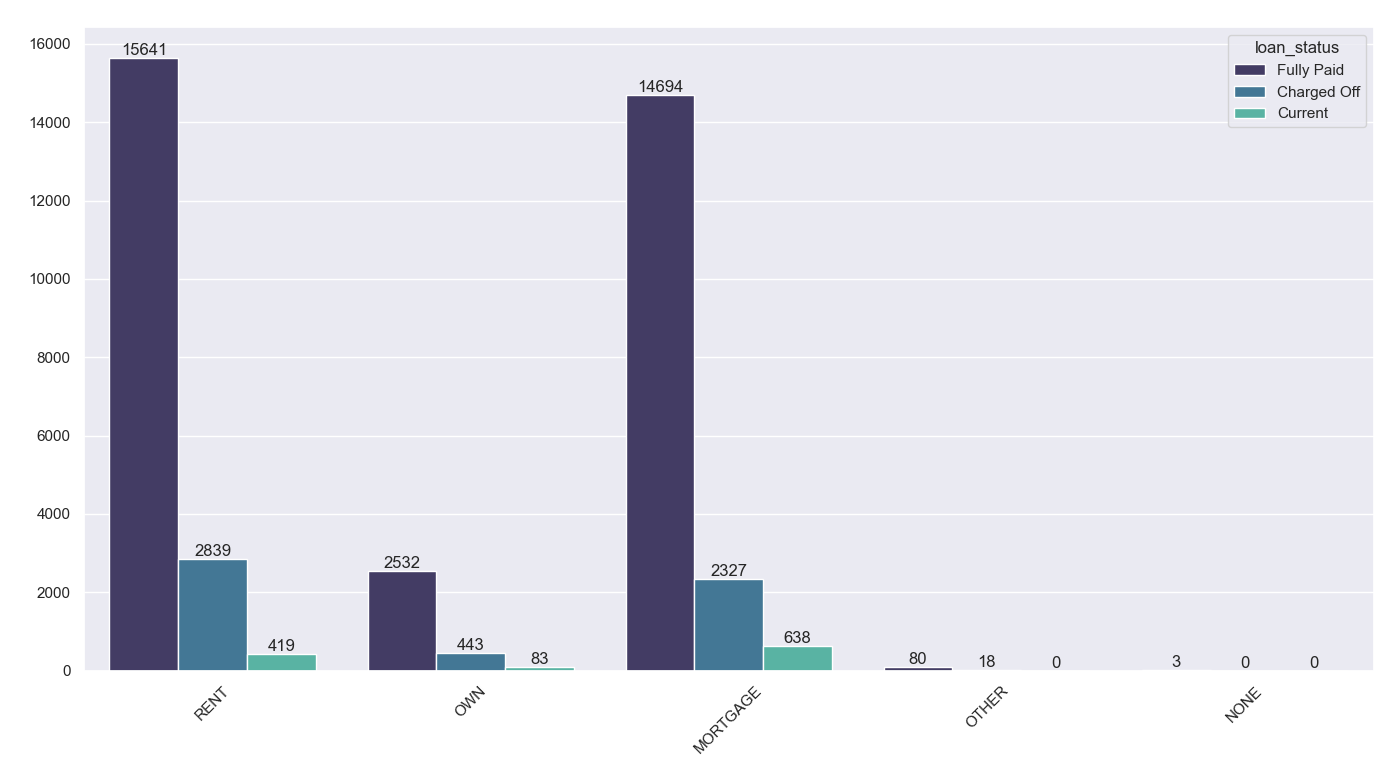

In [549]:
# catgorical analysis for Term with respect to loan status
plot_cat_analysis(loan_data_df,'home_ownership', 'loan_status')

### Analysis
1. Percentage of Charged off is highest with respect to consumer with Rent 
2. Higest number of loan is paid by consumer with rented home

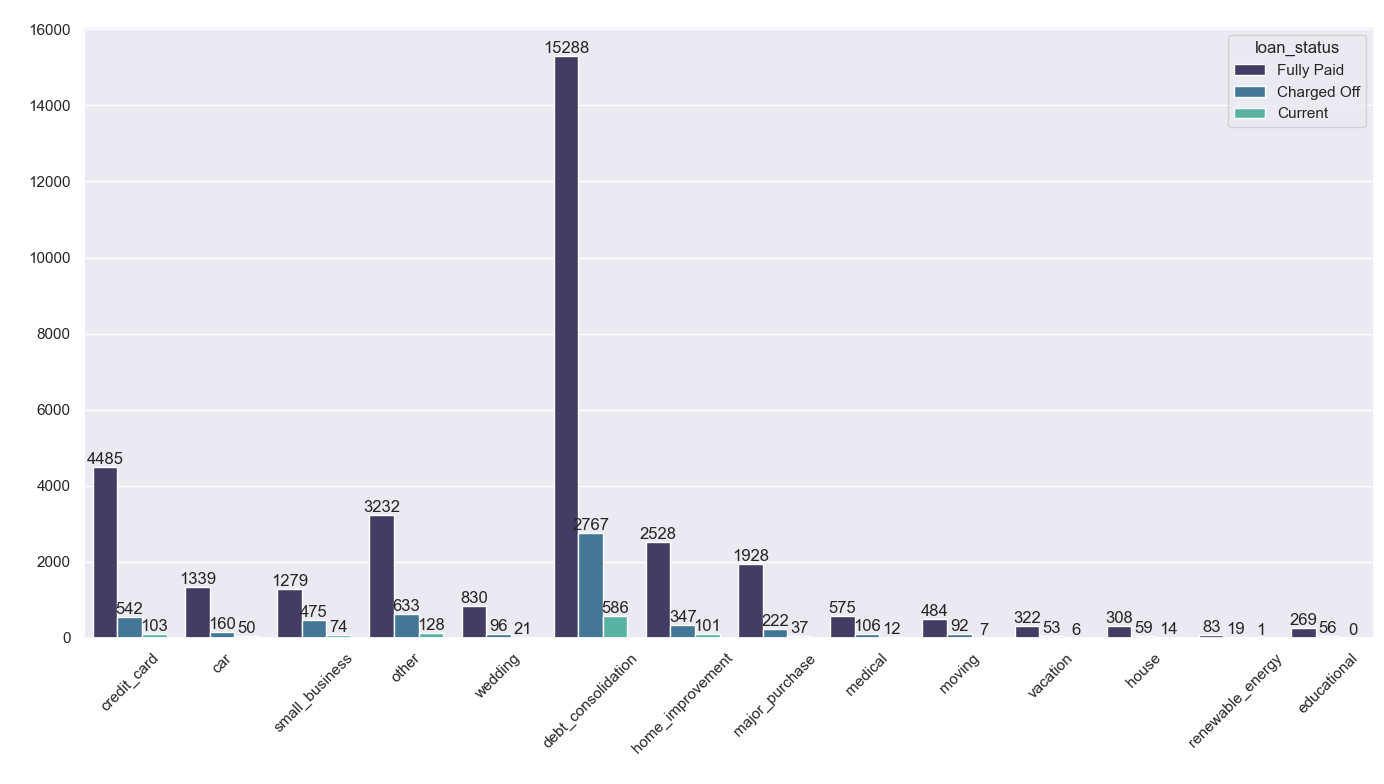

In [536]:
# catgorical analysis for purpose with respect to loan status
plot_cat_analysis(loan_data_df,'purpose', 'loan_status')

### Analysis
1. Percentage of Charged off is highest for consumer with debt_consolodation
2. Percentage of fully paid is highest with respect  with debt_consolodation

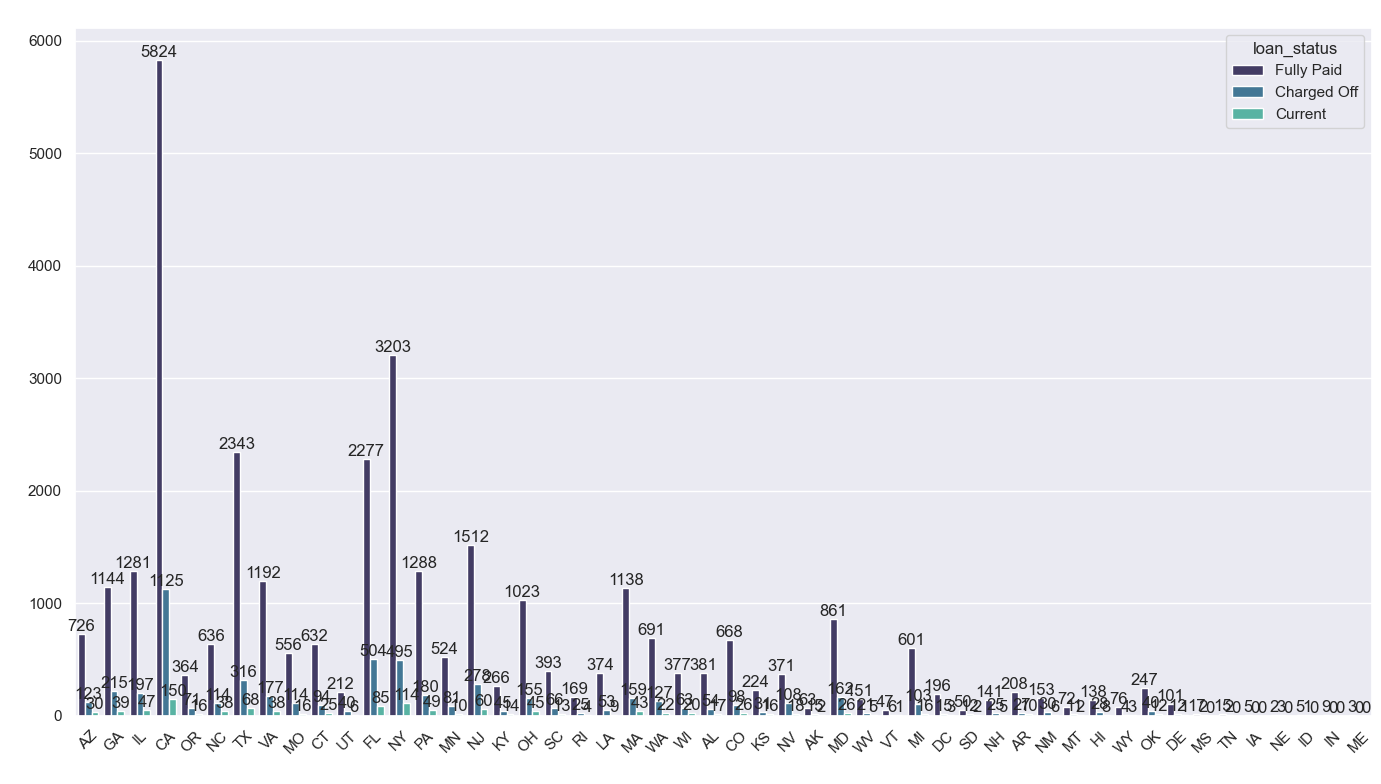

In [537]:
# catgorical analysis for addr_state with respect to loan status
plot_cat_analysis(loan_data_df,'addr_state', 'loan_status')

### Analysis
1. Percentage of Charged off is highest in CA
2. Percentage of fully paid is highest in CA

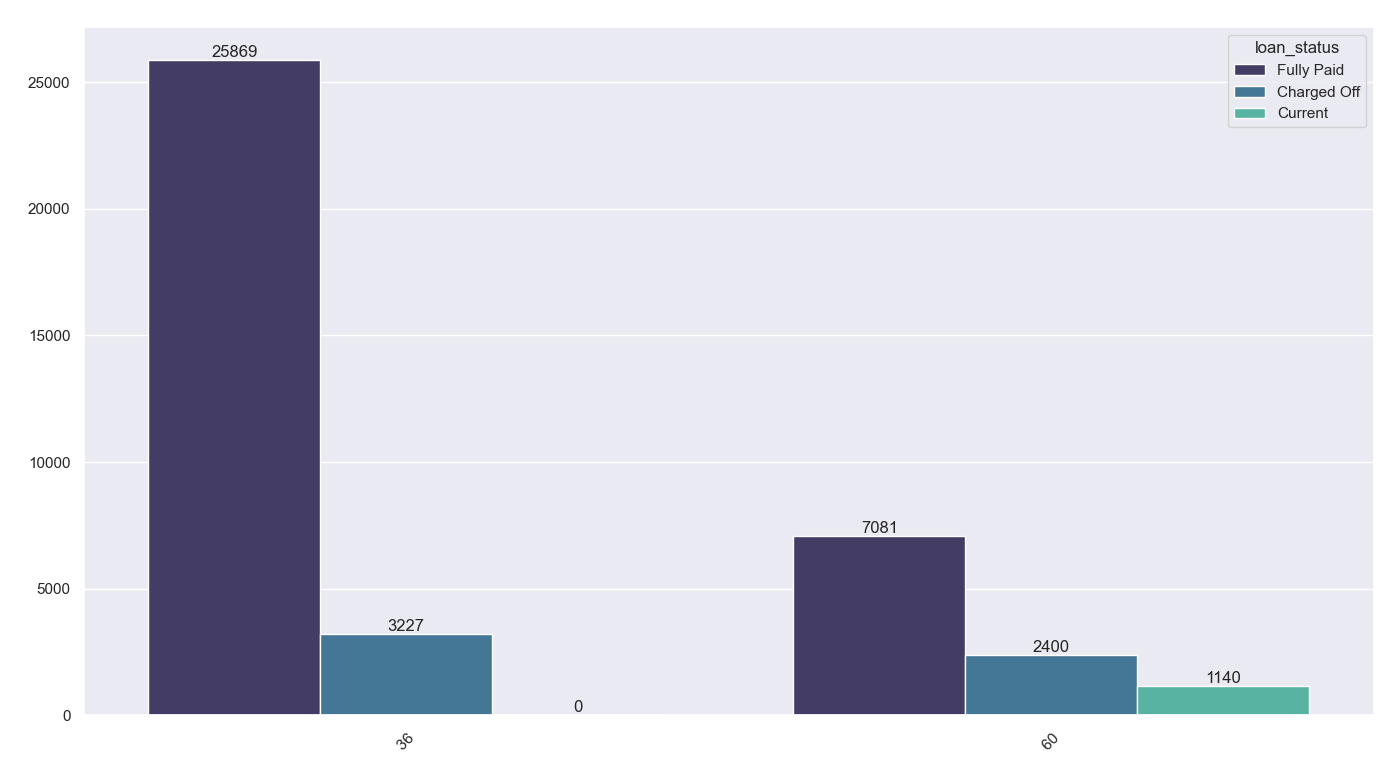

In [534]:
# catgorical analysis for Term with respect to loan status
plot_cat_analysis(loan_data_df,'term', 'loan_status')

### Analysis
1. There is not current loan going with term of 36 month
2. Percentage of loan to charged off is highest in term of 60 years

In [ ]:
1. term
2. grade
3. emp_length
4. pub_rec_bankruptcies

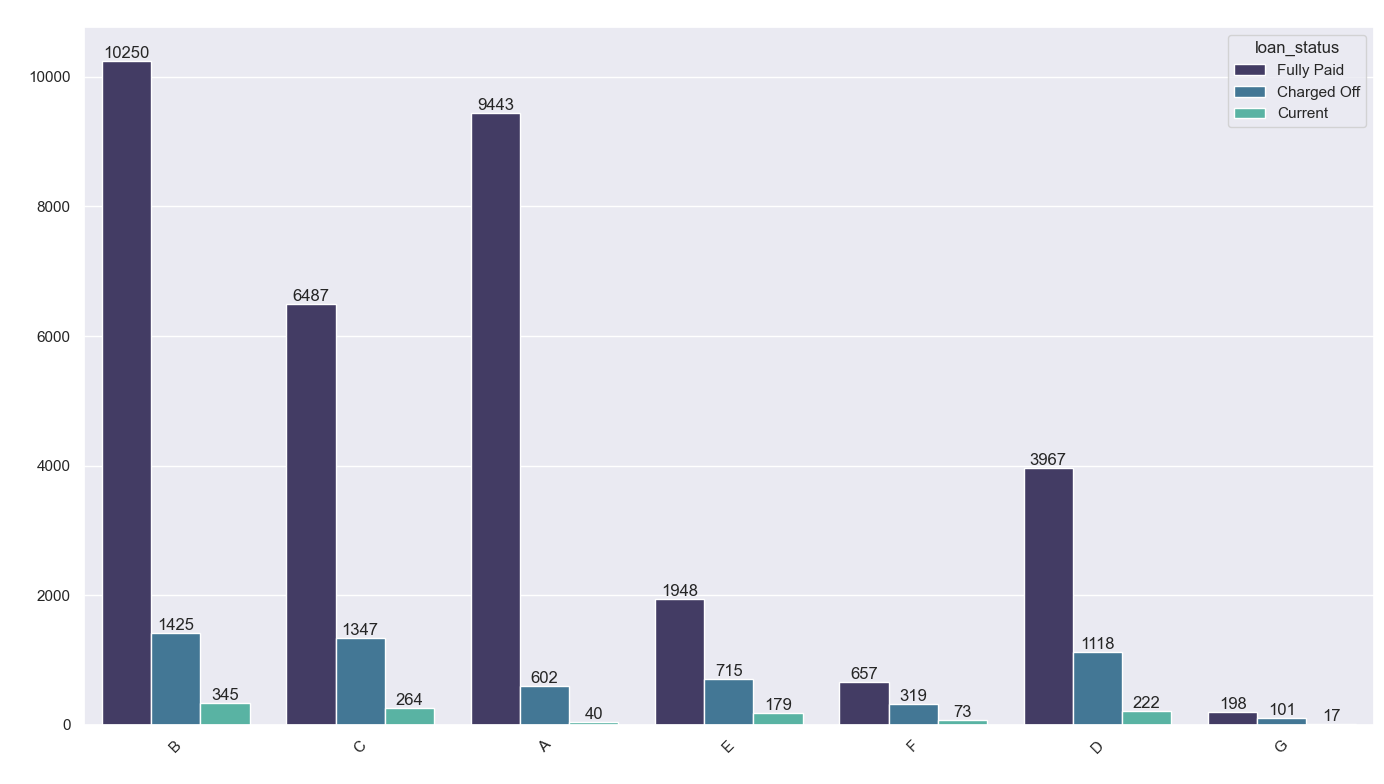

In [546]:
# catgorical analysis for grade with respect to loan status
plot_cat_analysis(loan_data_df,'grade', 'loan_status')

### Analysis
1. Consumer in category B has highest fully paid 
2. Highest Number of charged off is in B categroy

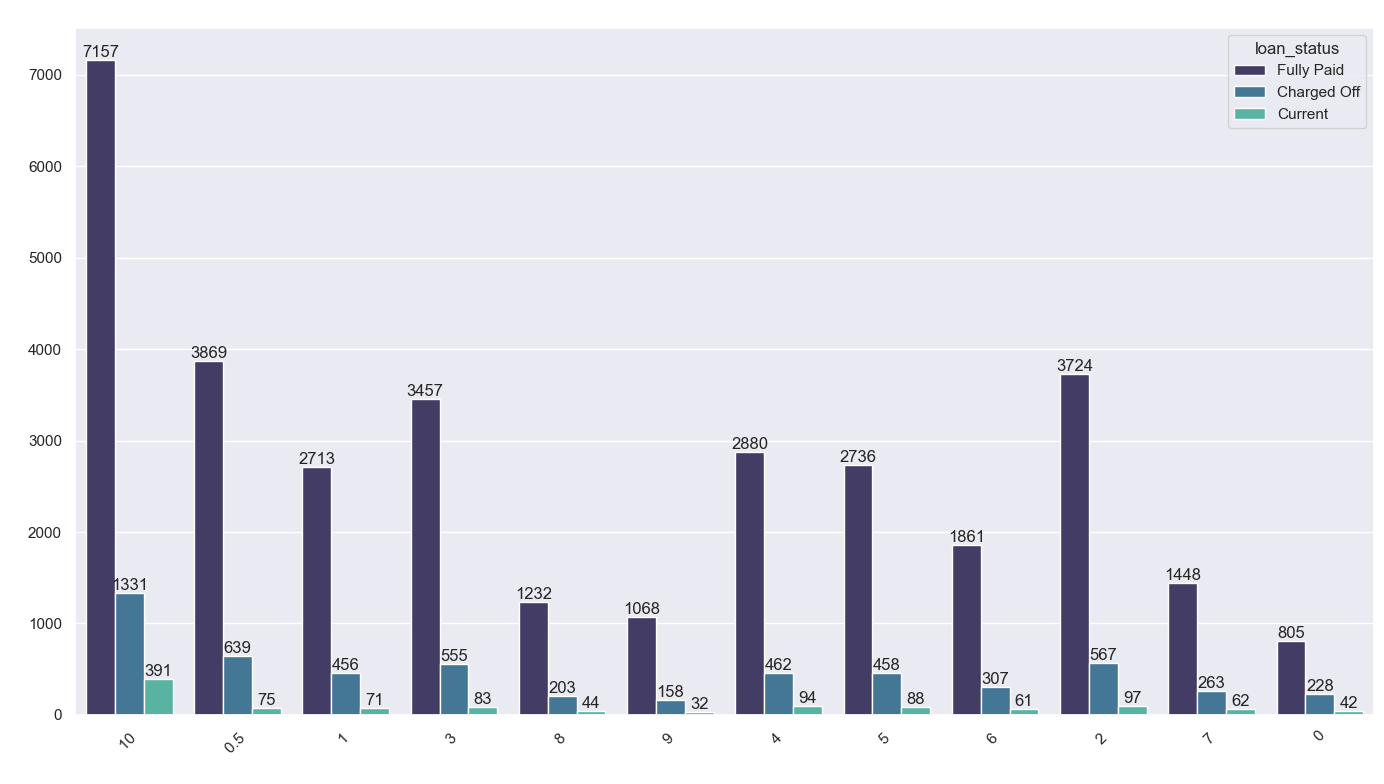

In [542]:
# catgorical analysis for grade with respect to loan status
plot_cat_analysis(loan_data_df,'emp_length', 'loan_status')

### Analysis
1. Consumer with 10 years experience has highest fully paid laon


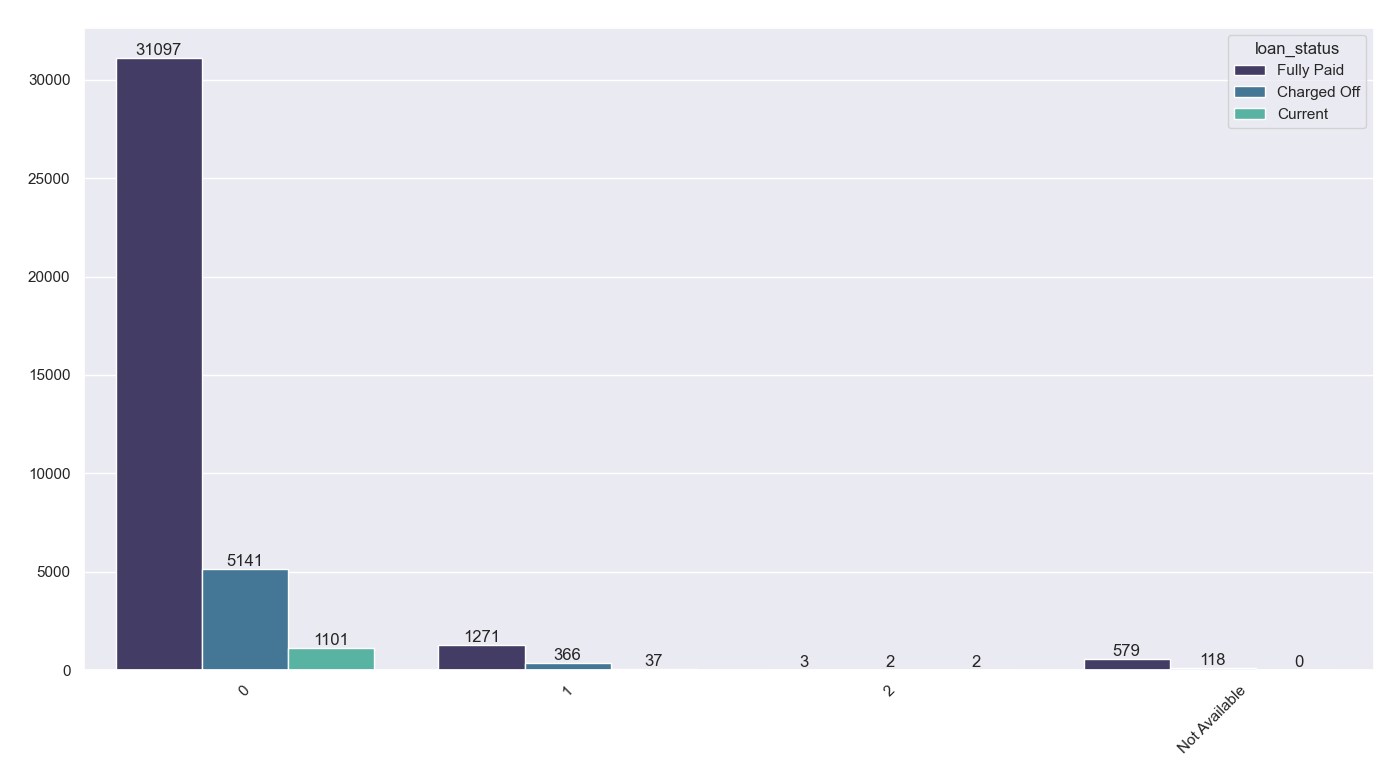

In [543]:
# catgorical analysis for pub_rec_bankruptcies with respect to loan status
plot_cat_analysis(loan_data_df,'pub_rec_bankruptcies', 'loan_status')

### Analysis
Majority of the loan applicants are in the category with no public record of bankruptcies

# Correlation Analysis

In [736]:
loan_corr =  loan_data_df
loan_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7927 entries, 0 to 39716
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       7927 non-null   object        
 1   loan_amnt                7927 non-null   int64         
 2   funded_amnt              7927 non-null   int64         
 3   funded_amnt_inv          7927 non-null   float64       
 4   term                     7927 non-null   int64         
 5   int_rate                 7927 non-null   float64       
 6   installment              7927 non-null   float64       
 7   grade                    7927 non-null   object        
 8   sub_grade                7927 non-null   object        
 9   emp_length               7927 non-null   object        
 10  home_ownership           7927 non-null   object        
 11  annual_inc               7927 non-null   float64       
 12  verification_status      7927 non

/var/folders/7y/3_wb9f8n2tg7jvq80z23zqyr0000gn/T/ipykernel_15004/4145727424.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_corr_matrix = loan_corr.corr()


<Figure size 1200x800 with 0 Axes>

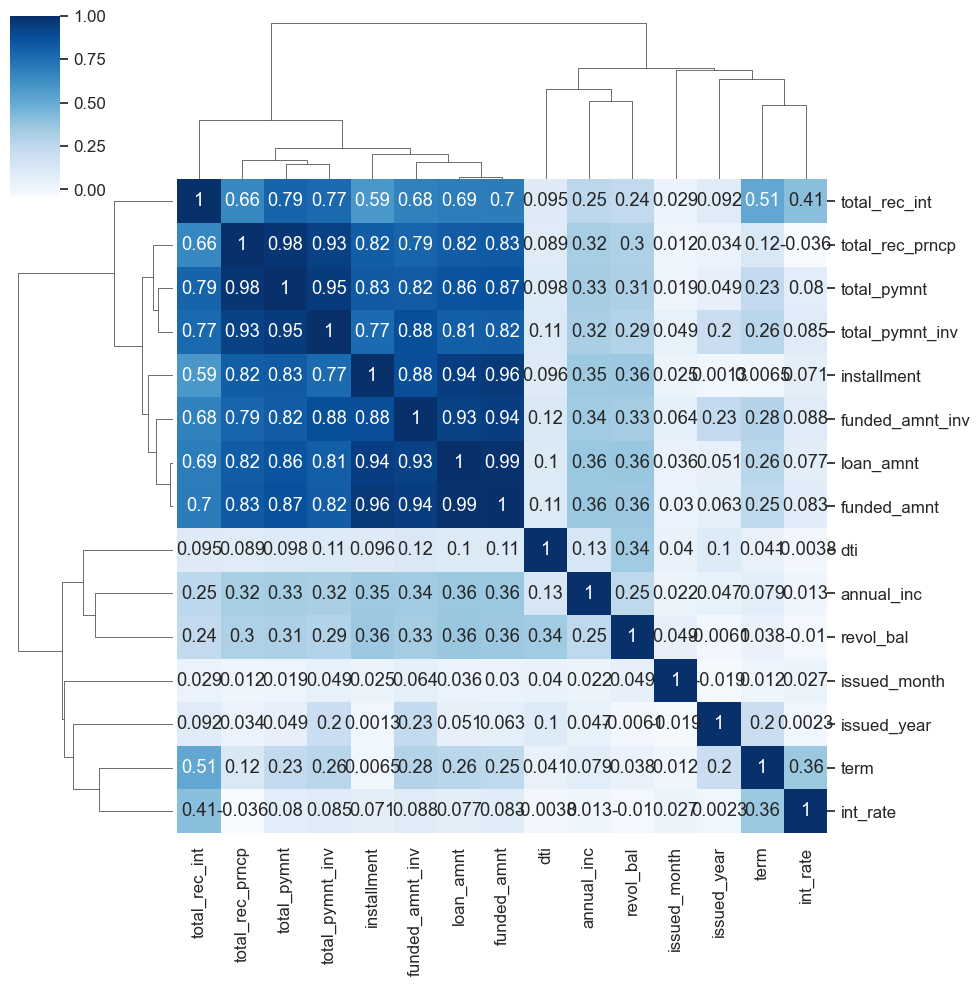

In [737]:
# creating correlation
loan_corr_matrix = loan_corr.corr()
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 8))
sns.clustermap(loan_corr_matrix, annot=True, cmap="Blues")
plt.show()

### data cleaning


In [738]:
drop_columns = ['installment','issued_year', 'issued_month','installment']
loan_corr = loan_corr.drop(columns=drop_columns)

/var/folders/7y/3_wb9f8n2tg7jvq80z23zqyr0000gn/T/ipykernel_15004/4260652375.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_corr_matrix = loan_corr.corr()


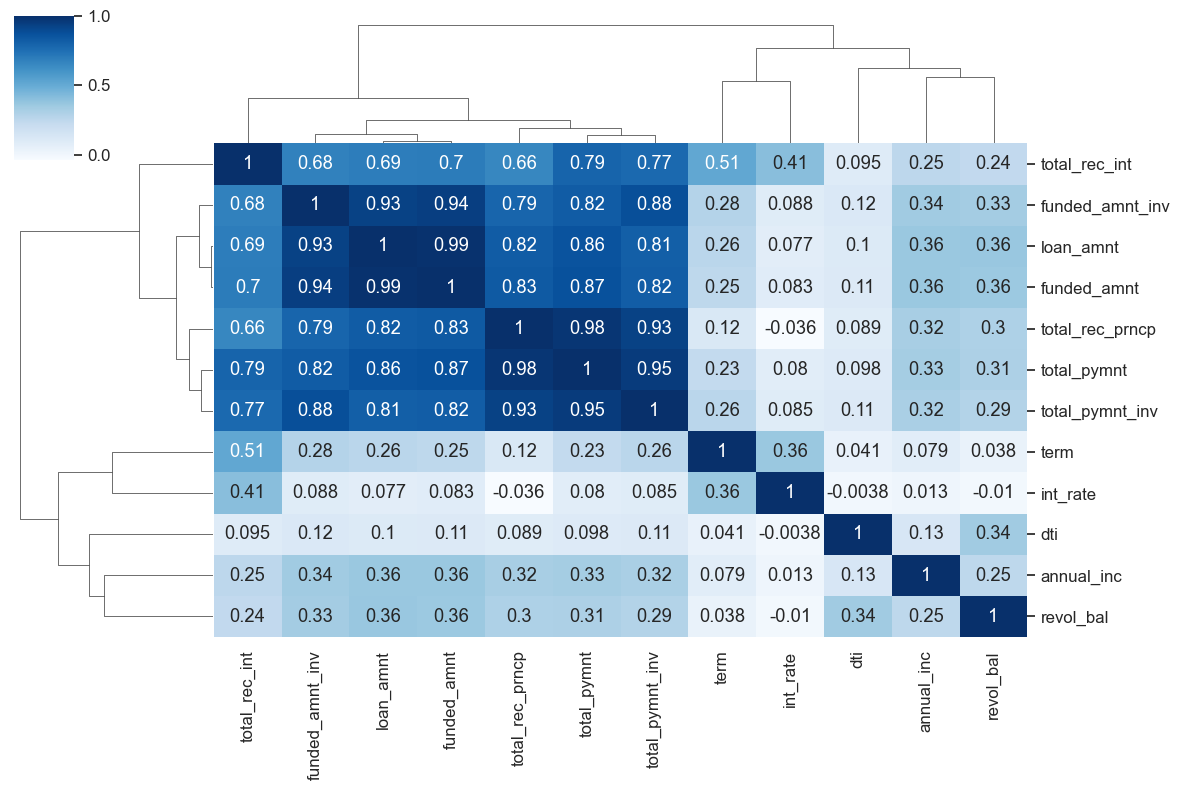

In [739]:
loan_corr_matrix = loan_corr.corr()
sea.set(font_scale=1.1)
sea.clustermap(loan_corr_matrix, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()

# Analysis

1. Strong positive correlations exist between loan amount, investor amount, and funding amount. Larger loans tend to attract more investors and higher funding, as larger loans often require multiple investors for funding.

2. A negative correlation is observed between annual income and the debt-to-income ratio (DTI). As annual income increases, the DTI tends to decrease, indicating that applicants with higher incomes allocate a smaller percentage of their income to debt payments, indicating better financial health.

3. The debt-to-income ratio (DTI) measures the proportion of monthly income used for debt payments. Lower annual income tends to result in a higher DTI, indicating a larger share of income allocated to debt servicing. Conversely, higher annual income is associated with a lower DTI, reflecting a healthier financial situation.

4. A positive correlation between annual income and years of employment suggests that income tends to increase with more work experience, aligning with the expectation that individuals with more work experience earn higher incomes due to career progression and higher wages. These observations provide valuable insights into the interactions and impacts of financial and employment-related variables on financial outcomes.

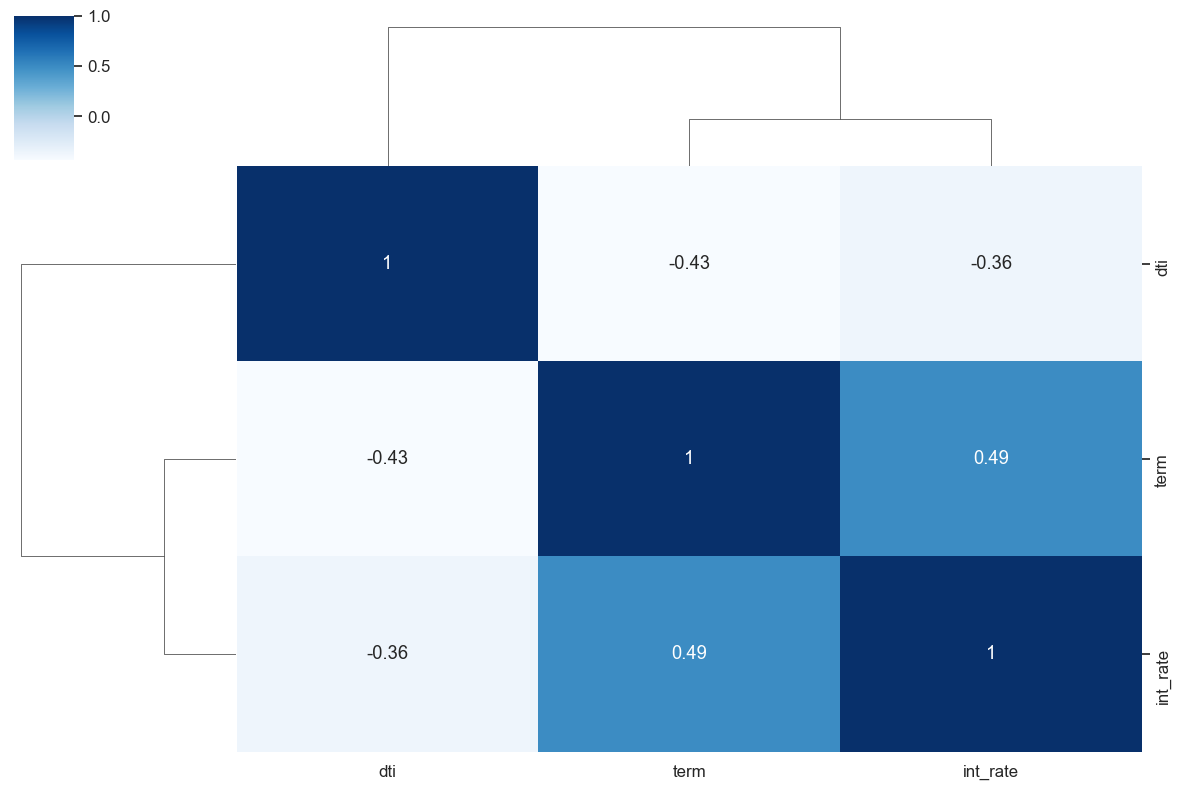

In [742]:
corr = loan_corr_matrix.loc[:, [ 'term', 'int_rate', 'dti']].corr()
sea.set(font_scale=1.1)
sea.clustermap(corr, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()